# Introduction
Before anything, do take a look at srcV1/\_tutorials to get a rough idea of how our algorithm is used to draw the synthetic data we designed. Those tutorials use version of codes, but our version 2 codes for generating data are practically the same.

In [1]:
import os
os.chdir('../../') # we run our script from two levels above (where main.py is)

import torch
import numpy as np
import matplotlib.pyplot as plt

TUTORIAL_DIR = 'src/_tutorials/example'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
from src.utils import to_batch_one_tensor
from src.xai import compute_single_data_attribution,compute_attribution_score

# Load Model
We have trained a simple model on a 3-class data. Let's load it.

In [3]:
from src.model import mabSPA
net = mabSPA().to(device=device)
checkpoint = torch.load(f"{TUTORIAL_DIR}/mabmodel_10_1.pt")
net.load_state_dict(checkpoint['model_state_dict'])
net.eval()
print('model loaded!')

model loaded!


# Fetching a few data


In [4]:
from src.data import load_dataset_from_a_shard, save_one_chunk

SHARD_DIR = f"{TUTORIAL_DIR}/data.shard"
dargs = {'n_classes':3, 'n_per_shard':4,}
save_one_chunk(SHARD_DIR, dargs['n_classes'], dargs['n_per_shard'], realtime_update=False)
samples = load_dataset_from_a_shard(SHARD_DIR, reshape_size=None)

  data prepared.                                                


# Heatmap model

In [5]:
import captum
from captum.attr import GuidedGradCam
attrmodel = GuidedGradCam(net, net.convs['2'])

# Result


 ============ sample 0 ============


C:\Users\ericotjoa\miniconda3\envs\xai_basic\lib\site-packages\captum\attr\_core\guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


metrics_collection:
 thresholds                       pixel_acc  recall     precision  FPR        
[-0.7 -0.3  0.3  0.7]            0.589      0.004      0.711      0.001     
[-0.695 -0.295  0.295  0.695]    0.589      0.004      0.709      0.001     
[-0.69 -0.29  0.29  0.69]        0.589      0.004      0.705      0.001     
[-0.685 -0.285  0.285  0.685]    0.589      0.004      0.712      0.001     
[-0.68 -0.28  0.28  0.68]        0.589      0.004      0.719      0.001     
[-0.675 -0.275  0.275  0.675]    0.589      0.004      0.724      0.001     
[-0.67 -0.27  0.27  0.67]        0.589      0.005      0.735      0.001     
[-0.665 -0.265  0.265  0.665]    0.59       0.005      0.743      0.001     
[-0.66 -0.26  0.26  0.66]        0.59       0.005      0.745      0.001     
[-0.655 -0.255  0.255  0.655]    0.59       0.005      0.754      0.001     
[-0.65 -0.25  0.25  0.65]        0.59       0.006      0.761      0.001     
[-0.645 -0.245  0.245  0.645]    0.59       0.006     

metrics_collection:
 thresholds                       pixel_acc  recall     precision  FPR        
[-0.7 -0.3  0.3  0.7]            0.648      0.001      0.317      0.002     
[-0.695 -0.295  0.295  0.695]    0.648      0.001      0.303      0.002     
[-0.69 -0.29  0.29  0.69]        0.648      0.001      0.298      0.002     
[-0.685 -0.285  0.285  0.685]    0.648      0.001      0.291      0.002     
[-0.68 -0.28  0.28  0.68]        0.648      0.002      0.293      0.002     
[-0.675 -0.275  0.275  0.675]    0.648      0.002      0.288      0.002     
[-0.67 -0.27  0.27  0.67]        0.648      0.002      0.294      0.002     
[-0.665 -0.265  0.265  0.665]    0.648      0.002      0.303      0.002     
[-0.66 -0.26  0.26  0.66]        0.648      0.002      0.325      0.002     
[-0.655 -0.255  0.255  0.655]    0.648      0.002      0.327      0.003     
[-0.65 -0.25  0.25  0.65]        0.648      0.002      0.317      0.003     
[-0.645 -0.245  0.245  0.645]    0.648      0.003     

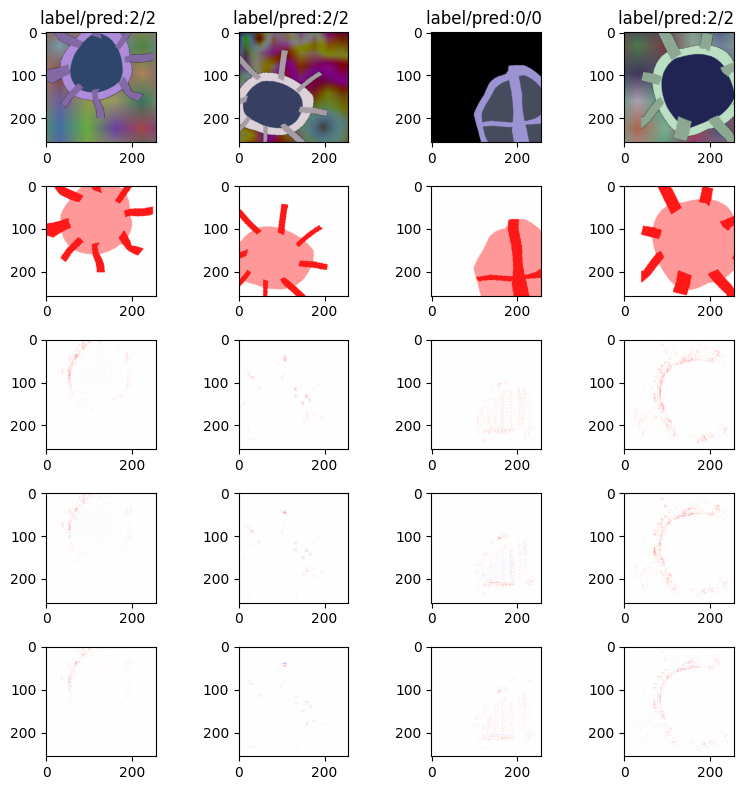

In [6]:
%matplotlib inline
plt.figure(figsize=(8,8))

with torch.no_grad():
    for i in range(dargs['n_per_shard']):
        print(f'\n ============ sample {i} ============')
        x,y0 = samples.__getitem__(i) # in numpy like (C,H,W) and int respectively
        h0 = samples.h[i] # in numpy, like (H,W), the groundtruth heatmap
    
        net.forward_mode = 'label+heatmap'
        y,h = net(to_batch_one_tensor(x, device=device))
        y_pred = torch.argmax(y,dim=1)[0].detach().cpu().numpy()
        
        ########## XAI part here ############
        net.forward_mode = None
        config_data = {'xai_mode': 'GuidedGradCam'}
        attr = compute_single_data_attribution(to_batch_one_tensor(x, device=device), int(y_pred), attrmodel, config_data)
        _ = compute_attribution_score(int(y_pred), int(y0), attr, h0, display_only=True)

        # normalize, similar to how it is computed in soft_fiveband_score, but channel is preserved 
        attr = attr/np.max(np.abs(attr)) 
        
        ########## let's plot ###############
        print(f'x.shape:{x.shape}   label/pred:{y0}/{y_pred}    h0.shape:{h0.shape} ') 
        print(f'attr.shape:{attr.shape}, max:{np.max(attr)}, min:{np.min(attr)}')
        plt.gcf().add_subplot(5,dargs['n_per_shard'],i+1)
        plt.gca().imshow(x.transpose(1,2,0))
        plt.gca().set_title(f'label/pred:{y0}/{y_pred} ')
        plt.gcf().add_subplot(5,dargs['n_per_shard'],i+1 + dargs['n_per_shard'])
        plt.gca().imshow(h0, vmin=-1,vmax=1.,cmap='bwr')

        plt.gcf().add_subplot(5,dargs['n_per_shard'],i+1 + 2* dargs['n_per_shard'])
        plt.gca().imshow(attr[0], vmin=-1,vmax=1.,cmap='bwr')
        plt.gcf().add_subplot(5,dargs['n_per_shard'],i+1 + 3*dargs['n_per_shard'])
        plt.gca().imshow(attr[1], vmin=-1,vmax=1.,cmap='bwr')
        plt.gcf().add_subplot(5,dargs['n_per_shard'],i+1 + 4*dargs['n_per_shard'])
        plt.gca().imshow(attr[2], vmin=-1,vmax=1.,cmap='bwr')
        
    plt.tight_layout()
    plt.show()